# Bike Sharing Demand by Random Forest

# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('data/test.csv', parse_dates=['datetime'])

df_train.shape, df_test.shape

((10886, 12), (6493, 9))

# Feature Engineering

### datetime으로 부터 연, 월, 일, 시간, 분, 초, 요일 추출

In [3]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second
df_train["dayofweek"] = df_train["datetime"].dt.dayofweek

In [4]:
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour
df_test["minute"] = df_test["datetime"].dt.minute
df_test["second"] = df_test["datetime"].dt.second
df_test["dayofweek"] = df_test["datetime"].dt.dayofweek

In [5]:
df_train.shape, df_test.shape

((10886, 19), (6493, 16))

###  풍속이 0인 데이터 채우기

풍속이 0인 데이터는 실제 풍속이 0인 게 아니라 기록이 되지 않아 0으로 채웠을 것임. 따라서 해당 데이터를 적절한 값으로 채워주어야 함.
null 값을 채우는 가장 일반적으로 방법은 평균값을 넣어주는 것임. 하지만 예측의 정확도를 위해 머신러닝으로 예측해서 풍속을 넣어주도록 하겠음

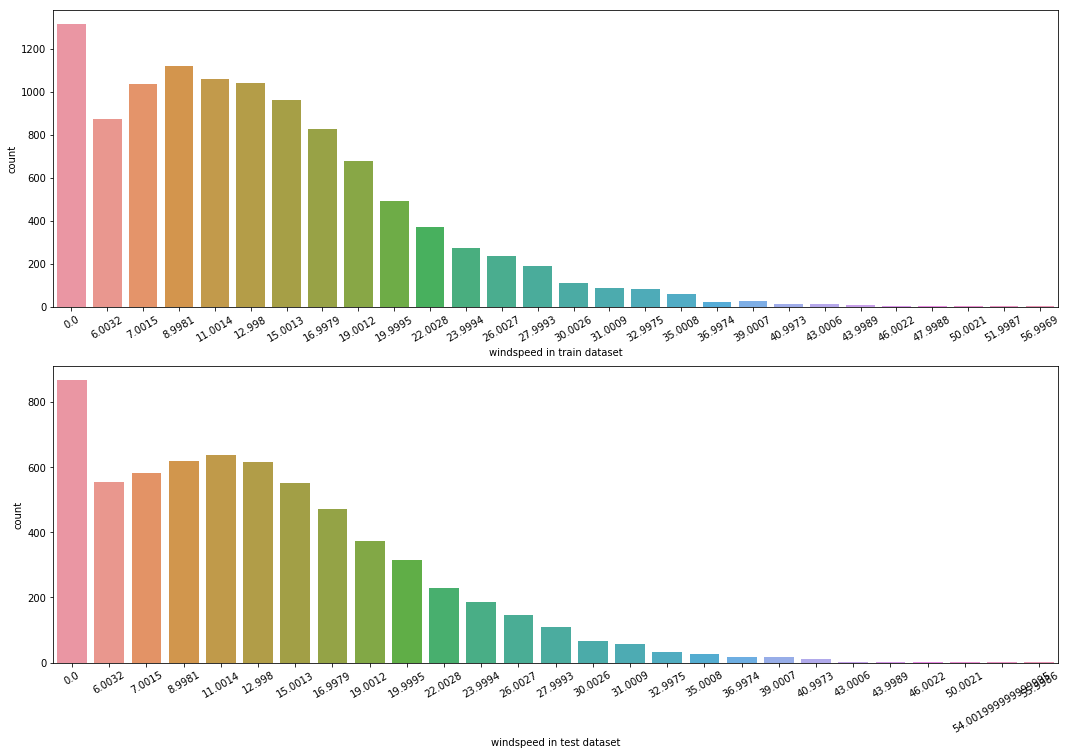

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(18, 12)

plt.sca(axes[0])
plt.xticks(rotation=30)
sns.countplot(data=df_train, x='windspeed', ax=axes[0])
axes[0].set(xlabel='windspeed in train dataset')

plt.sca(axes[1])
plt.xticks(rotation=30)
sns.countplot(data=df_test, x='windspeed', ax=axes[1])
axes[1].set(xlabel='windspeed in test dataset');

In [7]:

from sklearn.ensemble import RandomForestClassifier

def get_df_with_predicted_windspeed(df_train):  
    
    # windspeed가 0인 df와 0이 아닌 df로 나누기
    df_train_wind_zero = df_train.loc[df_train['windspeed']==0]
    df_train_wind_not_zero = df_train.loc[df_train['windspeed']!=0]

    # 풍속을 예측할 피처를 선택한다.
    wind_train_features = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    df_train_wind_not_zero["windspeed"] = df_train_wind_not_zero["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    wind_classifier = RandomForestClassifier()

    # windspeed_train_features에 있는 피처 값을 바탕으로 풍속을 학습시킨다.
    wind_classifier.fit(df_train_wind_not_zero[wind_train_features], df_train_wind_not_zero["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind_prediction = wind_classifier.predict(X = df_train_wind_zero[wind_train_features])

    # 값을 다 예측 후 비교해 보기 위해 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predict_wind_zero = df_train_wind_zero
    predict_wind_not_zero = df_train_wind_not_zero

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predict_wind_zero["windspeed"] = wind_prediction

    # 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    df_train = predict_wind_not_zero.append(predict_wind_zero)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    df_train["windspeed"] = df_train["windspeed"].astype("float")

    df_train.reset_index(inplace=True)
    df_train.drop('index', inplace=True, axis=1)
    
    return df_train

In [8]:
# windspeed 0 값에 대한 feature engineering
df_train = get_df_with_predicted_windspeed(df_train)

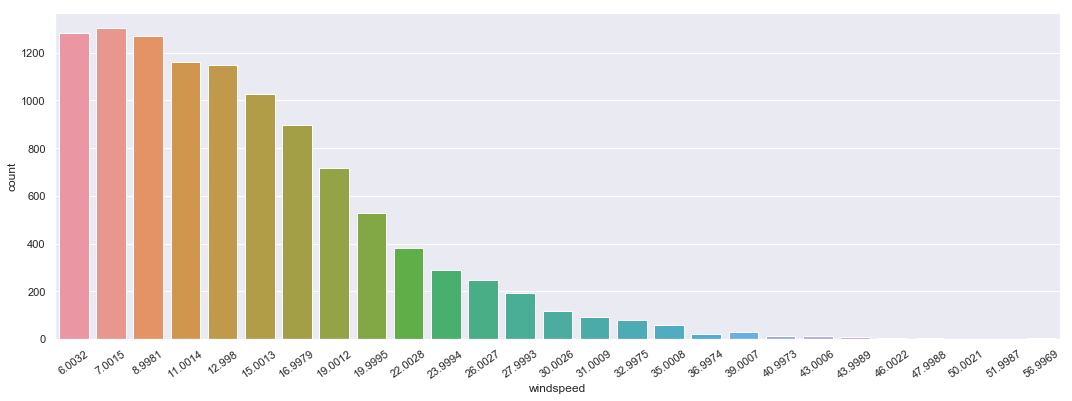

In [9]:
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=35)
sns.countplot(data=df_train, x='windspeed');

# Feature Selection

feature가 너무 많으면 오버피팅, 너무 적으면 언더피팅이 됨. 따라서 성능이 좋은 feature를 잘 선택해주어야 함

### 범주형 Feature type 변경

In [12]:
# day, minute, second는 training feature로 적절하지 않으므로 제외함
categorical_feature = ['season', 'holiday', 'workingday', 'weather',
                       'dayofweek', 'year', 'month', 'hour']
for feature in categorical_feature:
    df_train[feature] = df_train[feature].astype('category')
    df_test[feature] = df_test[feature].astype('category')

### Feature selection

In [14]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [15]:
X_train = df_train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [16]:
X_test = df_test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


# Score
### RMSLE

과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

${n}$ is the number of hours in the test set
$p_i$ is your predicted count
$a_i$ is the actual count
$\log(x)$ is the natural logarithm

좀 더 자세한 설명은 : RMSLE cost function

잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해

정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.
값이 작을 수록 오류가 적다는 의미를 나타낸다.